# Legal Abortion in Mexico City, 2016 to 2018

### Julia Martinez

In [ ]:
! pip install fiona geopandas xgboost gensim folium pyLDAvis descartes

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import geopandas as gpd

## Introduction
Abortion in developing countries has long been a topic of controversy, especially due to the clandestine and unsafe nature of the abortions carried out in countries where these are illegal and inaccessible. In Mexico, the laws governing abortion differ across states: Mexico City stands out as an exception, where elective abortions have been legal since 2007, up to the 12th week of pregnancy. However, outside of Mexico City, the majority of states have restrictive laws, permitting abortion only in cases of rape, risk to the woman's life, or severe fetal abnormalities. These inconsistencies in legislation have led to significant challenges for women seeking safe and legal abortions, with many resorting to clandestine procedures that pose health risks.

This project presents a comprehensive analysis of factors determining legal abortion access in Mexico. By examining different variables, I will compare the socioeconomic status of women who have undergone legal abortions with those of the general female population. In addition, I will explore the geographical distribution of women who had abortions, mapping their prevalence across different states and municipalities. Finally, I will seek to provide an approximation of abortions happening beyond the "legal framework" and draw comparisons between the profile of women accessing legal versus illegal abortions.


To explore the determinants of abortion access in Mexico, I'll start by analyzing a large dataset made public by the Mexico City Government on legal abortions carried out across the city between 2016 and 2018. It offers insights on a range of factors affecting each woman's situation, including abortion-related information, such as contraceptive use, number of pregnancies and complications in the process, and personal data such as age, marital status, employment status, religion, etc. I'll first start by importing and cleaning the dataset. 

*Note that this dataset is only available in Spanish, so the variable names are by default in Spanish. I've translated them whenever relevant.*

In [34]:
Abortion_2016_18 = pd.DataFrame(pd.read_csv("ile-2016-2018_2.csv",low_memory=False))

# convert the date of admission in the clinic ("fecha ingreso") to a datetime object
Abortion_2016_18["fecha_ingreso"] = pd.to_datetime(Abortion_2016_18["fecha_ingreso"]) 
Abortion_2016_18.set_index("fecha_ingreso",inplace=True)

Abortion_2016_18.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 51354 entries, 2016-04-01 to 2016-01-07
Data columns (total 40 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   año                        51354 non-null  int64  
 1   mes                        51354 non-null  object 
 2   referida                   13636 non-null  object 
 3   estado_civil               50872 non-null  object 
 4   edad                       51354 non-null  int64  
 5   institucion_derechohab     51256 non-null  object 
 6   nivel_edu                  51060 non-null  object 
 7   ocupacion                  44681 non-null  object 
 8   religion                   46931 non-null  object 
 9   parentesco                 16422 non-null  object 
 10  entidad                    51344 non-null  object 
 11  alc_o_municipio            47811 non-null  object 
 12  edad_primera_menstruacion  48934 non-null  object 
 13  edad_inicio_vida_sexual    48

We can see that this dataframe contains 40 different variables and 51354 rows, which represents the number of abortions carried out legally in Mexico City between 2016 and 2018. I'll now focus on studying the following variables: age ("edad"), highest education level achieved ("nivel_edu"), employment status ("ocupacion"), religion ("religion'), marital status ("estado civil"), State of residency ("entidad"), and municipality of residency ("alc_o_municipio"). For each one, I'll compare the distribution of women from this dataset (a.k.a. women who've had an abortion) with the distribution of the general female population in Mexico. To get this data I'll refer to different databases from official statistics provided by the government or by government-recognized agencies.

But first, just to get a grasp of what sort of data we're looking at, I'll plot the distribution of women who've had an abortion across age, employment and marital status on their own.

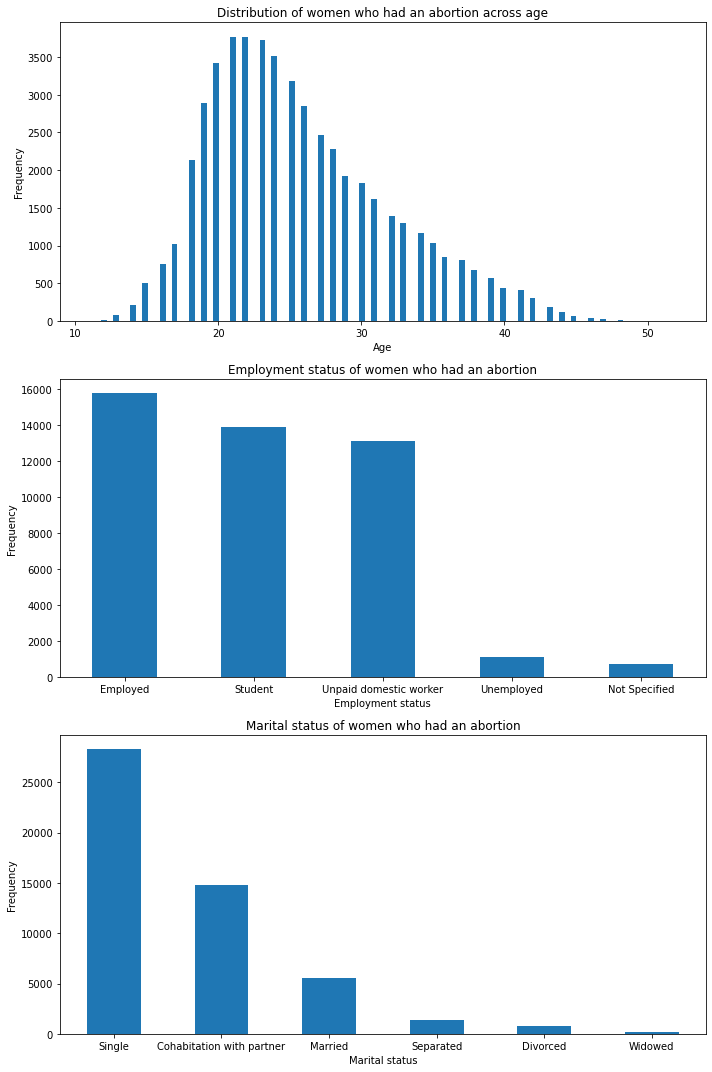

In [13]:
fig, ax = plt.subplots(3, figsize=(10,15))

# 1st subplot: distribution of women across age
ax[0].hist(Abortion_2016_18["edad"],bins=100)
ax[0].set_title("Distribution of women who had an abortion across age")
ax[0].set_xlabel("Age")
ax[0].set_ylabel("Frequency")

# 2nd subplot: distribution of women according to their employment status
freq_employment = Abortion_2016_18["ocupacion"].value_counts()
freq_employment.plot(kind='bar',ax=ax[1])

x_labels=["Employed","Student","Unpaid domestic worker","Unemployed","Not Specified"] 
# Note that unpaid domestic worker is separate from unemployment because these women are not actively looking for a job, 
# therefore they are out of the labour force, same as students
x_ticks=[0,1,2,3,4]
ax[1].set_xticks(x_ticks,x_labels,rotation=0)
ax[1].set_title("Employment status of women who had an abortion")
ax[1].set_ylabel("Frequency")
ax[1].set_xlabel("Employment status")

# 3rd subplot: distibution of women according to their marital status
freq_marital = Abortion_2016_18["estado_civil"].value_counts()
freq_marital.plot(kind='bar',ax=ax[2])

x2_labels=["Single","Cohabitation with partner","Married","Separated","Divorced","Widowed"]
x2_ticks=[0,1,2,3,4,5]
ax[2].set_title("Marital status of women who had an abortion")
ax[2].set_xticks(x2_ticks,x2_labels,rotation=0)
ax[2].set_ylabel("Frequency")
ax[2].set_xlabel("Marital status")

fig.tight_layout()

We can identify a few characteristics from these graphs:
- The age distribution is right-skewed, that is, there's more young females having abortions than older women. Abortion, at least legal abortion, is thus more common among the younger population.
- There's a pretty equal distribution among the employed, student and unpaid domestic worker groups - we'd have to see how these compare to the general population before reaching any conclusion.
- It's about 5 time more likely for a woman who had an abortion to be single than to be married, and about twice as likely than to live with their partner. This will be compared with the general population distribution too, but it makes sense intuitively, as married women are more likely to have the financial stability required to have a child, while single women may struggle to combine their career with childcare, making them more likely to have an abortion.

## Age Distribution

While we already know that abortion, at least legal abortion, is more common in the younger population, it's useful to compare it with the distribution of women of childbearing age. It's particularly insighful to compare it with the age distribution of women who just gave birth, as this might be slightly different than the general female population aged 15 to 50 (in general, more women in the lower end of the distribution become pregnant and have children than in the upper end). To get this data, I'll refer to a report released in 2016 by the National Institute of Statistics and Geography (*Instituto Nacional de Estadística y Geografía, INEGI*), which presents a lot of information regarding the Mexican female and male population. The data on age distribution of women who just gave birth is found in page 46, Graph 2.9., and it's grouped in ranges of 5 years, so I'll do the same with the Abortion dataset.


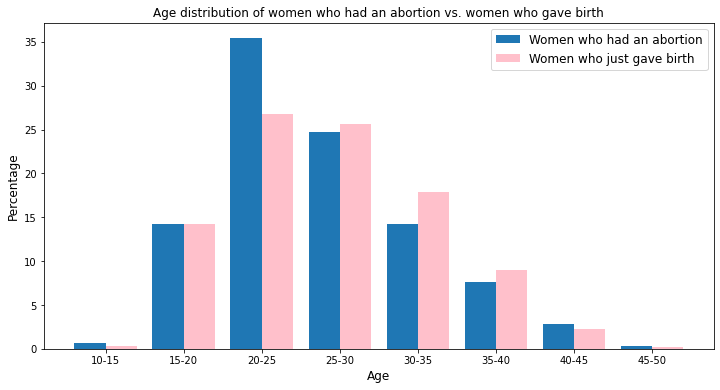

In [14]:
fig, ax = plt.subplots(figsize=(12,6))

age_mothers_dict = {
    "10":0.31,
    "15":14.21,
    "20":26.77,
    "25":25.62,
    "30":17.87,
    "35":8.95,
    "40":2.25,
    "45":0.19,
}

age_mothers = pd.Series(age_mothers_dict)

Abortion_age_freq = Abortion_2016_18["edad"].value_counts() # get the frequency of each age

Abortion_age_sorted = Abortion_age_freq.sort_index() # sort by increasing age
Abortion_age_grouped = Abortion_age_sorted.groupby((Abortion_age_sorted.index // 5) * 5).agg(sum) # group in 5-year ranges
Abortion_age_grouped.drop(50,inplace=True) # drop the 50+ years old group, as the age_mothers dataset doesn't contain this information
Abortion_age_pct = 100 * Abortion_age_grouped/Abortion_age_grouped.sum() # take the relative weight (percentage) of each group for direct comparison of both datasets

# Plot both datasets side-by-side
X_axis = np.arange(8)

plt.bar(X_axis - 0.2, Abortion_age_pct, 0.4, label = 'Women who had an abortion')
plt.bar(X_axis + 0.2, age_mothers, 0.4, label = 'Women who just gave birth',color="pink")

ax.set_title("Age distribution of women who had an abortion vs. women who gave birth")
ax.set_xlabel("Age",fontsize=12)
ax.set_ylabel("Percentage",fontsize=12)
ax.set_xticks([0,1,2,3,4,5,6,7],["10-15", "15-20","20-25","25-30","30-35","35-40","40-45","45-50"])
ax.legend(fontsize=12);


We see that in the younger (10 - 25 y.o.) and the older (40-50 y.o.) age ranges, the percentage of women who had abortions are equal or higher than that of women who just had a child. This validates my initial hypothesis that younger women are more likely to have an abortion than older women, even when accounting for the fact that younger women have more pregnancies than older women. 

This can stem from financial instability of younger generations, as many haven't landed a good and stable job yet, and therefore may not feel economically prepared to raise a child. In addition, it could also stem from younger generations being more open to liberal ideas surrounding reproductive rights, including abortion. 

*Note that this graph doesn't indicate that, for example in range 20-25, there's more women having abortions than women having children (this is in fact not true). It indicates than the percentage of women having an abortion when they're aged 20-25, out of the total women having abortions, is higher than the percentage of women having children when they're aged 20-25, out of the total women having children.*

## Employment Status
Moving on, I'll now compare the distribution of women according to their employment status. Because the original dataset only includes the categories of employed, unemployed, student, unpaid domestic worker, and unspecified, and it doesn't include information on income or working conditions, it's difficult to match these categories to certain economic status. For example, while we might think that an unemployed woman is in more financial distress than an employed one, that's not necessarily true - it could perfectly be that the former is very well-off and looking for a new job, while the latter has a very low-paying job and lives paycheck to paycheck. Therefore, I'll look at education levels as a better indicator of socioeconomic status. For now, however, let's focus on employment status.

To get information on the general female population, I've used the INEGI report (page 170), along with information on the 2016 female unemployment rate taken from the Integrated System of Statistics on Violence against Women (SIESVIM), an informative tool offered by INEGI. The rate is estimated to be 3.9%. Note that this rate only includes women who are actively looking for a job, but don't have one currently. The female labour participation force of Mexico is actually quite low, around 46% in 2016. 

From the INEGI report, 20,464,449 women are economically active. From these, the 3.9% represents about 800,000 unemployed women, and so the remaining 19,600,000 are employed.
We can also see that 26,682,064 women are not economically active - of these, around 4 million study and 22 million do unpaid domestic work. I'll classify the rest as "not specified".

Adding up the numbers and taking the relative percentages, we have that overall there's 27 million women aged 15 and above, of which:
- 800,000 are unemployed (1.7% of total)
- 19,600,000 are employed (41,7% of total)
- 4,000,000 are studying (8.5% of total)
- 22,000,000 do unpaid domestic work (46.8% of total)
- 600,000 are not specified (1.3% of total)


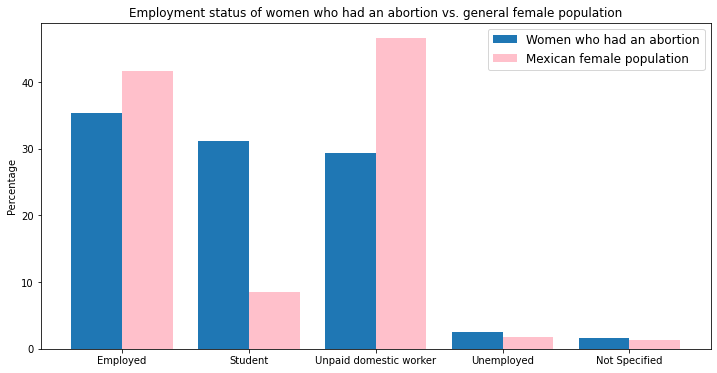

In [15]:
# Retrieve freq_employment from the Abortion dataset and find the relative percentage of each value
relative_ocupation = 100*freq_employment/freq_employment.sum()

# Create new dataframe with the distribution of the general female population, in percentages
distr_employment = {
    "EMPLEADA": 41.7,
    "ESTUDIANTE": 8.5,
    "TRABAJADORA DEL HOGAR NO REMUNERADA": 46.6,
    "DESEMPLEADA": 1.7,
    "NO ESPECIFICADO": 1.3,
}

distr_e = pd.Series(distr_employment)

# Plot
fig, ax = plt.subplots(figsize=(12,6))
X_axis = np.arange(5)

plt.bar(X_axis - 0.2, relative_ocupation, 0.4, label = 'Women who had an abortion')
plt.bar(X_axis + 0.2, distr_e, 0.4, label = 'Mexican female population',color="pink")
plt.legend(fontsize=12)
ax.set_xticks(x_ticks,x_labels,rotation=0)
ax.set_title("Employment status of women who had an abortion vs. general female population")
ax.set_ylabel("Percentage");


We can clearly see from this graph that, on the one hand, there's an overrepresentation of students. This might be explained by several reasons. First, we've already seen that there's an overrepresentation of young women, mainly aged 20-25, most of which are likely to be students. Second, for students there's a high opportunity cost of having children, since having them may jeopardize their academic performance, and ultimately the continuity in their studies. Moreover, students don't usually have the financial means to afford childcare, and may have to rely on family members to support them. Finally, another reason might again be the more open-minded mentality of young students which makes them more likely to have an abortion. 

Another thing to notice is an underrepresentation of unpaid domestic workers, which again may stem from various reasons. On the one hand, they may not have enough money to afford travelling all the way to where legal abortion centers are located (only in Mexico City and the State of Oaxaca). On the other hand, they might be staying at home rather than working because of traditional values held in the family, which would align with a negative sentiment around abortions. 

## Education Level

As mentioned earlier, the highest level of education achieved by each woman might be a better indicator of their socioeconomic status (given that I don't have information on their incomes). To compare it with the general population, I'm again referring to INEGI. From their online tool SIESVIM, I've been able to download an Excel table with data on the highest educaton level achieved by women, by age ranges from 15 to 40 years old. Before plotting, however, I need to rearrange both datasets so the information matches. 


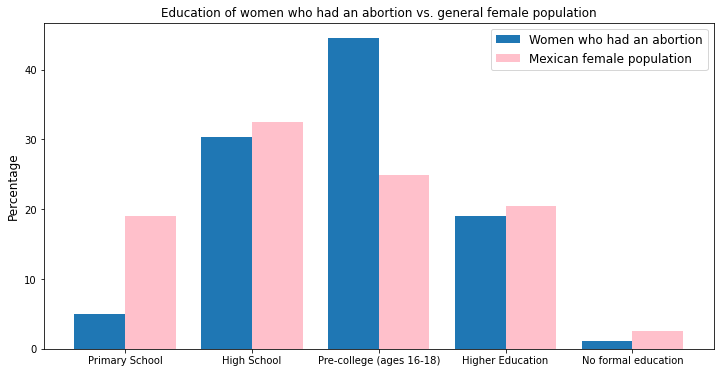

In [16]:
# First, import excel table "Education by levels"
Edu_mexico_1 = pd.read_excel("Educacion por niveles.xls")

# Take the frequency of the education levels from the Abortion dataset
Freq_Edu = Abortion_2016_18["nivel_edu"].value_counts()

# Add up the values of Licenciatura (Bachelor's), Maestria (Master's) and Doctorado (PhD) into "Higher Education", and drop the individual ones
Freq_Edu["EDUCACIÓN SUPERIOR"] = Freq_Edu["LICENCIATURA"] + Freq_Edu["MAESTRIA"] + Freq_Edu["DOCTORADO"]
Freq_Edu = Freq_Edu.drop(["LICENCIATURA","MAESTRIA","DOCTORADO"])

# Drop "Preescolar" from Edu_mexico_1 (equivalent to kindergarden), "No especificado" (not specified), and "Edad" (Age), since there's no such information in the Abortion dataset
Edu_mexico = Edu_mexico_1.drop(["Preescolar o kinder","No especificado","Edad"],axis=1)

# Compute the average across all ages in Edu_mexico and the relative percentages of Freq_edu: 
Edu_mean = Edu_mexico.mean()
Abortion_Edu = 100*Freq_Edu / Freq_Edu.sum() 

# Rearrange both lists according to increasing education levels: 
Abortion_Edu = Abortion_Edu.loc[["PRIMARIA","SECUNDARIA","PREPARATORIA","EDUCACIÓN SUPERIOR","SIN ACCESO A LA EDUCACION FORMAL"]]
Edu_mean = Edu_mean.loc[["Primaria","Secundaria","Preparatoria, bachillerato o equivalente","Educación superior", "Ninguno"]]

# Plot
fig, ax = plt.subplots(figsize = (12,6))
X_axis = np.arange(5)

plt.bar(X_axis - 0.2, Abortion_Edu, 0.4, label = 'Women who had an abortion')
plt.bar(X_axis + 0.2, Edu_mean, 0.4, label = 'Mexican female population',color="pink");

ax.set_title("Education of women who had an abortion vs. general female population")
ax.set_ylabel("Percentage",fontsize=12)
ax.set_xticks([0,1,2,3,4],["Primary School", "High School","Pre-college (ages 16-18)","Higher Education","No formal education"])
ax.legend(fontsize=12);

We can see here that women who had an abortion have higher levels of education compared to the general female population in Mexico, despite the "Higher Education" band being slightly below average (this is probably due to the fact that most women who had an abortion fell in the age range 20-25, where many women haven't graduated from university yet). If we focus on the "pre-college" level, which is more relevant and insightful in this situation, given than most women who had an abortion are above 18 years old, we see that the percentage of women who had an abortion that achieve that level of education almost doubles that of general Mexican women. Moreover, if we look at lower levels of education, we see that the percentage of women that only completed "Primary School" or didn't receive formal education at all is higher for the general female population than for those who had an abortion. 

In all, this indicates very clearly that women who have access to legal abortion services come from more highly educated backgrounds than those who don't have access to these services. As such, this is a good indicator that socioeconomic status matters when it comes to accessing abortion. As it'll be discussed later on, most of the women who don't have access to legal abortion services don't refrain from having abortions - they still have them, but in unsafe, sometimes life-threatening conditions, not performed by medical staff and usually without the necessary tools and resources. The fact that only women from high socioeconomic backgrounds can have access to the legal and safe abortions is therefore a very critical social issue that needs to be adressed. 

## Marital Status
Another interesting factor to analyze is the women's marital status, as there might be variations between those who abort and the general population. The data here is extracted from SIESVIM too, under the category "porcentaje de poblacion segun situacion conyugal" (percentage of population according to marital status). It has had data acrioss all age ranges, so I've selected 15 to 45 years old.

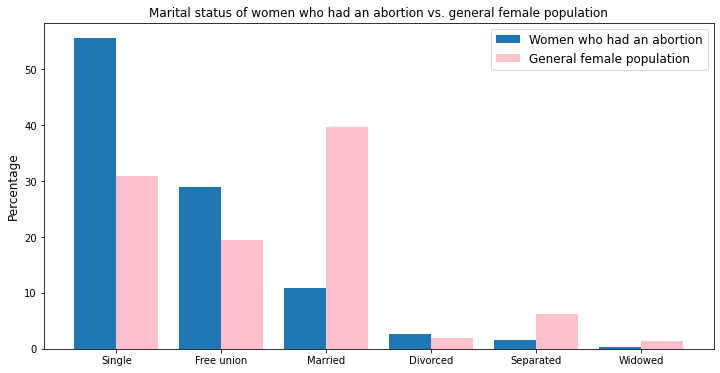

In [17]:
# Import Excel table and make edits
Marital_overall = pd.read_excel("SIESVIM - Marital Status.xls")

Marital_overall = Marital_overall.drop(6) # drop the "non-specified" because it's too small to be relevant.
Marital_overall.set_index("Situación conyugal",inplace=True) # set index to "Marital Status"
Marital_overall_mean = Marital_overall.mean(axis=1) # Take the mean across age ranges
Marital_overall_sorted = Marital_overall_mean.iloc[[0,2,1,4,3,5]] # sort by the order given by the Abortion dataset

# Find relative weights (percentages) of the abortion dataset
freq_marital = Abortion_2016_18["estado_civil"].value_counts()
Marital_pct = 100*freq_marital/freq_marital.sum()

fig, ax = plt.subplots(figsize = (12,6))
X_axis = np.arange(6)

plt.bar(X_axis - 0.2, Marital_pct, 0.4, label = 'Women who had an abortion')
plt.bar(X_axis + 0.2, Marital_overall_sorted, 0.4, label = 'General female population',color="pink")

ax.set_title("Marital status of women who had an abortion vs. general female population")
ax.set_ylabel("Percentage",fontsize=12)
ax.set_xticks([0,1,2,3,4,5],["Single", "Free union","Married","Divorced","Separated","Widowed"])
ax.legend(fontsize=12);

As predicted earlier, we see that women who have abortions are much more likely to be single and much less likely to be married compared to the overall female population. First, this can be explained by women who have abortions being generally young, which corresponds to higher chances of being single and not married. In fact, according to INEGI, the average age for marriage in Mexico is 28.5 years old, and the average age in the Abortion dataset is approximately 26: 

In [18]:
Abortion_2016_18["edad"].mean()

25.678973400319354

Second, women tend to be apprehensive to becoming single mothers for several reasons, including difficulties managing work and household responsibilities, lack of financial stability and/or other resources to raise a family by themselves, etc. Hence, if they are single, they will generally be more likely to have an abortion compared to if they were married. 

So we can look at these variations in a two-folded way:
- Women who are single are more likely to have an abortion compared to their married counterparts;
- Women who have had abortions are more likely to be single because they're generally younger than the average married women.

To shed some light on this issue, we can look at the subgroup of women who had an abortion and are over 25, and see how the resulting diagram changes. 

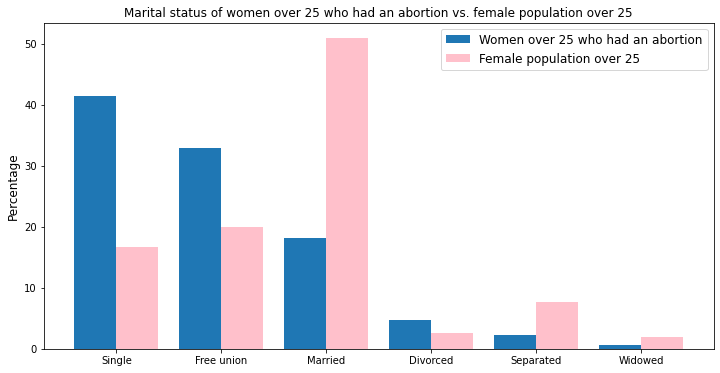

In [19]:
# Same diagram but with women over 25 only

Marital_25 = Abortion_2016_18.loc[Abortion_2016_18["edad"] > 25]
Marital_25f = Marital_25["estado_civil"].value_counts()
Marital_25_pct = 100*Marital_25f/Marital_25f.sum()

# Drop the categories "from 15 to 19" and "from 20 to 24" from the general population dataframe
# and take the average across the rest of the age ranges
Marital_mean_25 = Marital_overall.drop(["De 15 a 19 años","De 20 a 24 años"],axis=1).mean(axis=1)
Marital_mean_25 = Marital_mean_25.iloc[[0,2,1,4,3,5]] # rearrange to match the Abortion dataframe order

# Plot
fig, ax = plt.subplots(figsize = (12,6))
X_axis = np.arange(6)

plt.bar(X_axis - 0.2, Marital_25_pct, 0.4, label = 'Women over 25 who had an abortion')
plt.bar(X_axis + 0.2, Marital_mean_25, 0.4, label = 'Female population over 25',color="pink");

ax.set_title("Marital status of women over 25 who had an abortion vs. female population over 25")
ax.set_ylabel("Percentage",fontsize=12)
ax.set_xticks([0,1,2,3,4,5],["Single", "Free union","Married","Divorced","Separated","Widowed"])
ax.legend(fontsize=12);

We now see that the proportion of married women is higher in both groups, and the proportion of single is lower in both groups too. The differences between the groups in each category, however, remain almost exactly the same (about 20 percentage points in "Single" and about 30 percentage points in "Married"). This result indicates that it's not necessarily true that what's driving these variations is the fact that women who have abortions are generally young and therefore single. These discrepancies can be better explained by first idea presented earlier: that single women are more likely to have an abortion when they get pregnant compared to married women, probably due to financial instability, lack of resources to raise a child alone and incompatibility between their professional life and household responsibilities. 

## Religion
Finally, I found it interesting to study if there's any differences between the religion of the general population and that of women who have abortions. The intuitive thought here is that, in general, religious women might be more reluctant to have abortions than non-religious women. To compare the data from the Abortion dataset I've used information from the INEGI 2020 census. This is not classified by gender, so I will assume that there is a similar distribution of religions among both genders, which I consider reasonable. Note that the only significant categories identified are "catholic", "none", "christian", and "others", so I'll have to rearrangethe data from the Abortion dataset to match these. 


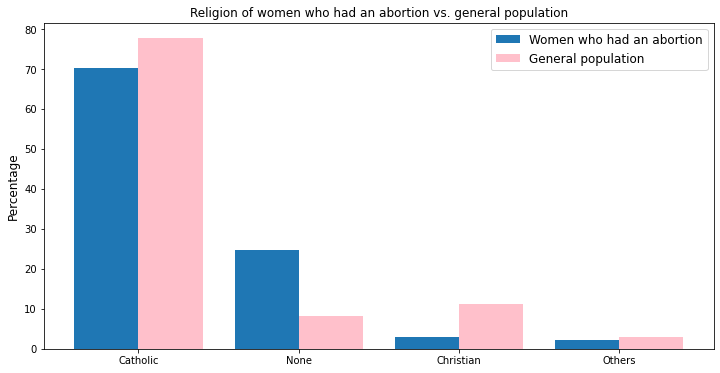

In [20]:
# Take the data from the abortion dataset and compute the relative frequency
Religion_abortion = Abortion_2016_18["religion"].value_counts()
Freq_rel = 100*Religion_abortion/Religion_abortion.sum()

# From the census data, create the general population Religion dataframe.
Religion_dict = {
    "CATOLICA": 77.7,
    "NINGUNA": 8.1,
    "CRISTIANA": 11.2,
    "OTRAS":3
}

Religion = pd.Series(Religion_dict)

# Because the different religions within "Others" account for a very small, almost irrelevant, percentage, I grouped them together
Freq_rel["OTRAS"]=Freq_rel["OTRA"] + Freq_rel["MORMONA"] + Freq_rel["TESTIGA DE JEHOVA"] + Freq_rel["BUDISTA"] + Freq_rel["JUDIA"] + Freq_rel["MUSULMANA"]
Freq_rel.drop(["OTRA","MORMONA","TESTIGA DE JEHOVA","BUDISTA","JUDIA","MUSULMANA"],inplace=True)

# Plot
fig, ax = plt.subplots(figsize = (12,6))
X_axis = np.arange(4)

plt.bar(X_axis - 0.2, Freq_rel, 0.4, label = 'Women who had an abortion')
plt.bar(X_axis + 0.2, Religion, 0.4, label = 'General population',color="pink");

ax.set_title("Religion of women who had an abortion vs. general population")
ax.set_ylabel("Percentage",fontsize=12)
ax.set_xticks([0,1,2,3],["Catholic", "None","Christian","Others",])
ax.legend(fontsize=12);

As we would've expected, we see that the proportion of non-religious women is much higher on the abortion group than on the general population group. This is compensated by a large decrease in the Christian female population and a slight decrease in the Catholic one. Again, this is a pretty reasonable and expected result, since most religions are openly anti-abortion and have rather traditional ideals around women's reproductive rights. 

# Geographical Distribution
Because of the geographical restrictions of access to abortion in Mexico, as legal abortion services are only offered in the capital and the State of Oaxaca, it's interesting to see where the women who've had abortions come from, and whether the traveling distance is indeed a barrier or not. In order to study this, I'll use Geopandas to plot the distribution of state and municipality of residency of the women in the abortion dataset, adjusted by population density. 

First, I need to import a dataset with geographical information of the States of Mexico , and then match it with the Abortion dataset, where all the states appear in capital letters and without accents or other symbols, so I need to write some of the State names manually. Finally I simply need to merge both datasets and plot them.

In [21]:
Mexico_states = gpd.read_file("https://gist.githubusercontent.com/walkerke/76cb8cc5f949432f9555/raw/363c297ce82a4dcb9bdf003d82aa4f64bc695cf1/mx.geojson")
print(Mexico_states.info())

# Adjust data from this GeoDataFrame to match the Abortion dataset States column ("entidades")

def upper(x):
    X = x.upper()
    return X

Mexico_states["name"] = Mexico_states["name"].apply(upper)

Mexico_states.loc[8,"name"] = "CIUDAD DE MEXICO"
Mexico_states.loc[14,"name"] = "ESTADO DE MEXICO"
Mexico_states.loc[15,"name"] = "MICHOACAN"
Mexico_states.loc[18,"name"] = "NUEVO LEON"
Mexico_states.loc[21,"name"] = "QUERETARO"
Mexico_states.loc[23,"name"] = "SAN LUIS POTOSI"
Mexico_states.loc[30,"name"] = "YUCATAN"
display(Mexico_states.head())


<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        32 non-null     int64   
 1   name      32 non-null     object  
 2   state     32 non-null     object  
 3   mus09     32 non-null     float64 
 4   pri10     32 non-null     float64 
 5   sec10     32 non-null     float64 
 6   ter10     32 non-null     float64 
 7   gdp08     32 non-null     float64 
 8   other10   32 non-null     float64 
 9   geometry  32 non-null     geometry
dtypes: float64(6), geometry(1), int64(1), object(2)
memory usage: 2.6+ KB
None


,id,name,state,mus09,pri10,sec10,ter10,gdp08,other10,geometry
0,1,AGUASCALIENTES,Aguascalientes,17.1,6.34,28.74,64.28,84.70,0.64,"MULTIPOLYGON (((-102.21140 22.35450, -102.1908..."
1,2,BAJA CALIFORNIA,Baja California,15.4,5.44,31.64,61.68,83.07,1.24,"MULTIPOLYGON (((-114.09429 28.02418, -114.0774..."
2,3,BAJA CALIFORNIA SUR,Baja California Sur,3.0,9.18,17.48,72.37,94.64,0.97,"MULTIPOLYGON (((-109.79843 24.15516, -109.8028..."
3,4,CAMPECHE,Campeche,7.0,19.24,21.20,57.11,395.55,2.45,"MULTIPOLYGON (((-91.52440 18.76659, -91.52457 ..."
4,5,CHIAPAS,Chiapas,13.9,42.76,13.51,42.90,34.44,0.83,"MULTIPOLYGON (((-93.97061 16.00979, -93.96390 ..."


,id,name,state,mus09,pri10,sec10,ter10,gdp08,other10,geometry,count
0,1,AGUASCALIENTES,Aguascalientes,17.1,6.34,28.74,64.28,84.70,0.64,"MULTIPOLYGON (((-102.21140 22.35450, -102.1908...",38
1,2,BAJA CALIFORNIA,Baja California,15.4,5.44,31.64,61.68,83.07,1.24,"MULTIPOLYGON (((-114.09429 28.02418, -114.0774...",16
2,3,BAJA CALIFORNIA SUR,Baja California Sur,3.0,9.18,17.48,72.37,94.64,0.97,"MULTIPOLYGON (((-109.79843 24.15516, -109.8028...",12
3,4,CAMPECHE,Campeche,7.0,19.24,21.20,57.11,395.55,2.45,"MULTIPOLYGON (((-91.52440 18.76659, -91.52457 ...",5
4,5,CHIAPAS,Chiapas,13.9,42.76,13.51,42.90,34.44,0.83,"MULTIPOLYGON (((-93.97061 16.00979, -93.96390 ...",27


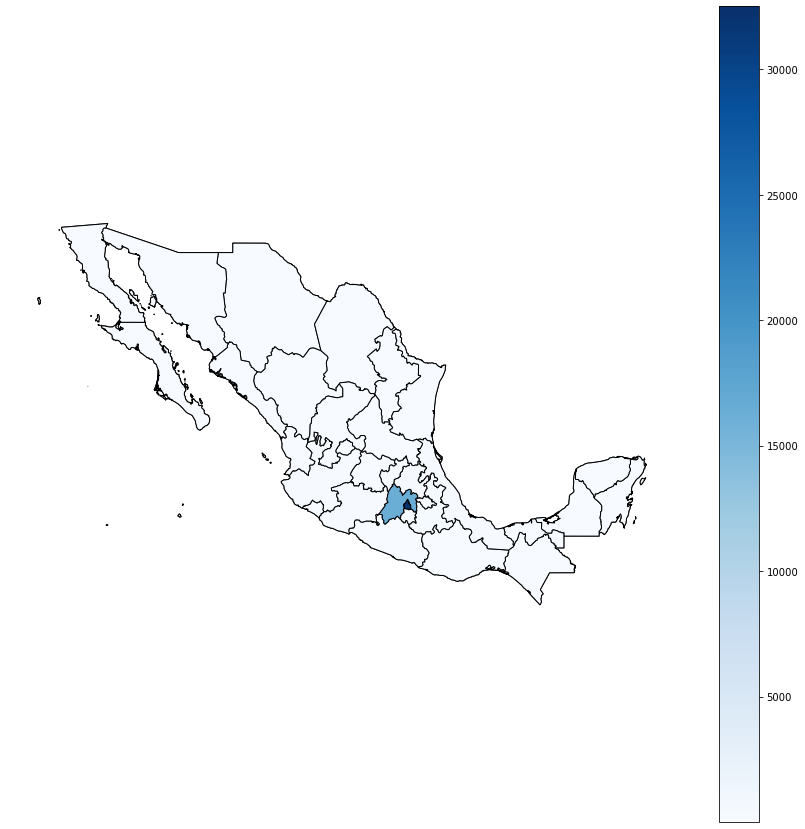

In [22]:
# Count the number of abortions per State
Freq_2016 = Abortion_2016_18["entidad"].value_counts()

# merge datasets
Merged_df = pd.merge(Mexico_states,Freq_2016,left_on="name",right_index=True)
display(Merged_df.head())

# Plot
fig, gax = plt.subplots(figsize=(15,15))
plt.axis('off')

Mexico_states.plot(ax=gax,edgecolor="black")
Merged_df.plot(ax=gax, edgecolor='black', column='count',cmap="Blues",legend=True);


We see clearly that, by far, most of the the women who receive abortions are from Mexico City and neighbouring states (in particular, Estado de Mexico). This is does not mean that only these women receive abortions - as mentioned earlier, most abortions that happen outside of Mexico City are deemed illegal and thus can't be reported in official statistics. In general, the women that are represented here tend to live close enough to Mexico City, where they can get legal abortions, so they are the only ones reported. Because of long distances and travelling costs, women from other parts of Mexico, especially those from low-income backgrounds, have to resort to doing unsafe and illegal abortions in their home states.


### Mexico City
Focusing now on the two states where most women who abort are from - that is, Mexico City and Estado de Mexico- I'll plot the distribution of these women by municipality and study whether there is any relation between rural/urban residency and abortion access. I've obtained the geographical location of the municipalities of Mexico City and Estado de Mexico from INEGI, specifically from the National GeoStatistical Framework. 


,CVE_ENT,CVE_MUN,CVEGEO,NOMGEO,geometry,count
0,09,002,09002,AZCAPOTZALCO,"POLYGON ((2791951.814 837586.813, 2791955.363 ...",1846
1,09,003,09003,COYOACÁN,"POLYGON ((2801514.816 820735.691, 2801516.200 ...",1251
2,09,004,09004,CUAJIMALPA DE MORELOS,"POLYGON ((2787229.791 825329.285, 2787272.744 ...",332
3,09,005,09005,GUSTAVO A. MADERO,"POLYGON ((2804455.193 837639.057, 2804458.490 ...",4837
4,09,006,09006,IZTACALCO,"POLYGON ((2808145.908 826363.205, 2808144.575 ...",1707


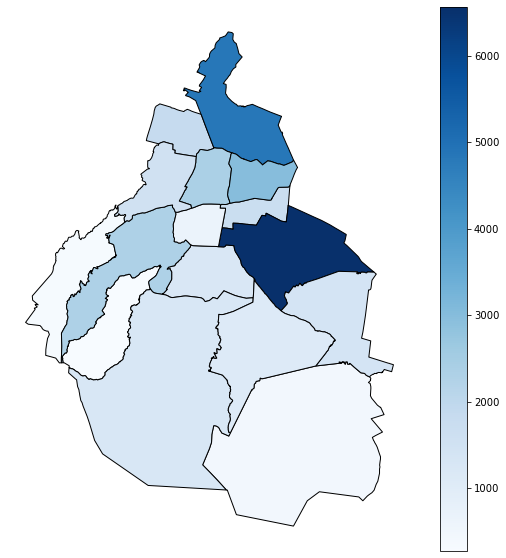

In [23]:
fig, gax = plt.subplots(figsize=(10,10))
plt.axis("off")

# This file contains the geographical location of the municipalities of Mexico City, abbreviated cdmx
cdmx1 = gpd.read_file("09mun.dbf")

# Clean the data so it matches that of the Abortion dataset
cdmx1["NOMGEO"] = cdmx1["NOMGEO"].apply(upper)
cdmx1.loc[14,"NOMGEO"]="MIGHEL HIDALGO"

# Obtain the data on municipalities from the Abortion dataset
Freq_municipal = Abortion_2016_18["alc_o_municipio"].value_counts()

# Merge and plot:
Merged_cdmx1 = pd.merge(cdmx1,Freq_municipal,left_on="NOMGEO",right_index=True)
Merged_cdmx1.plot(ax=gax,edgecolor='black', column='count',cmap="Blues",legend=True)
display(Merged_cdmx1.head())

The data on this graph can be quite misleading because I haven't accounted yet for the population density distribution. To do so, I need to import a file, obtained from the INEGI database too, that details the population of each municipality within Mexico City every 5 years.

/tmp/ipykernel_1057/648971790.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop2015["Alcaldia"] = pop2015["Alcaldia"].apply(upper)
/tmp/ipykernel_1057/648971790.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pop2015["Alcaldia"].iloc[10] = "MIGHEL HIDALGO"


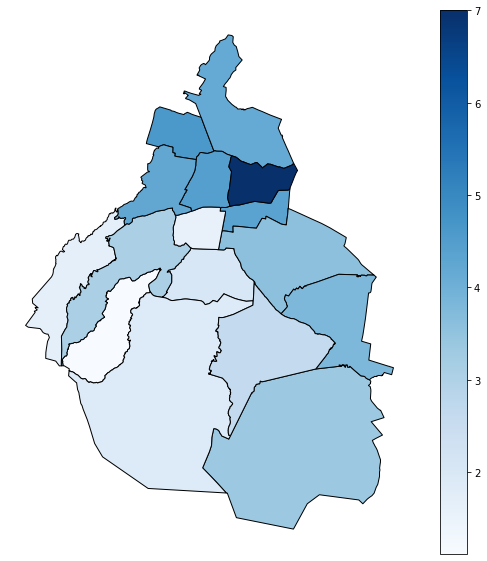

In [24]:
pop = pd.read_csv("poblacion_total_tasa_crecimiento_1.1.csv",thousands=',')
pop.set_index("Año", inplace=True) # Set index as the Year ("año")
pop2015 = pop.loc[2015] # select only the population data from 2015

# Edit the data so it matches the Merged_cdmx1 dataframe (upper case and a few minor edits)
pop2015["Alcaldia"] = pop2015["Alcaldia"].apply(upper)
pop2015["Alcaldia"].iloc[10] = "MIGHEL HIDALGO"

# Add the population information to the GeoDataFrame
Merged_pop = pd.merge(Merged_cdmx1,pop2015, left_on="NOMGEO",right_on="Alcaldia")

# Compute the ratio of each municipality's abortion cases by the population of that municipality, multiplied by 1000
Merged_pop["Ratio"] = 1000*Merged_pop["count"]/Merged_pop["Población total"]

# Plot
fig, gax = plt.subplots(figsize=(10,10))
plt.axis("off")
Merged_pop.plot(ax=gax, edgecolor="black",column="Ratio",cmap="Blues",legend=True);

Now that it accounts for population density, the map shows a more clear picture: the majority of abortions are from women that live in the northern part of Mexico City. And precisely, it is the North of the city where most of the wealth is concentrated, while the South is far less developed. Richer neighbourhoods of the city have greater abortion access than poorer neighbourhoods, which again indicates that, to some extent, access to legal abortion services does depend on socioeconomic status.

### State of Mexico
Finally, let's look at the other state with high abortion rates: State of Mexico. Again, I've imported the geographical information from the INEGI database, and the population distribution per municipality from the 2020 census.

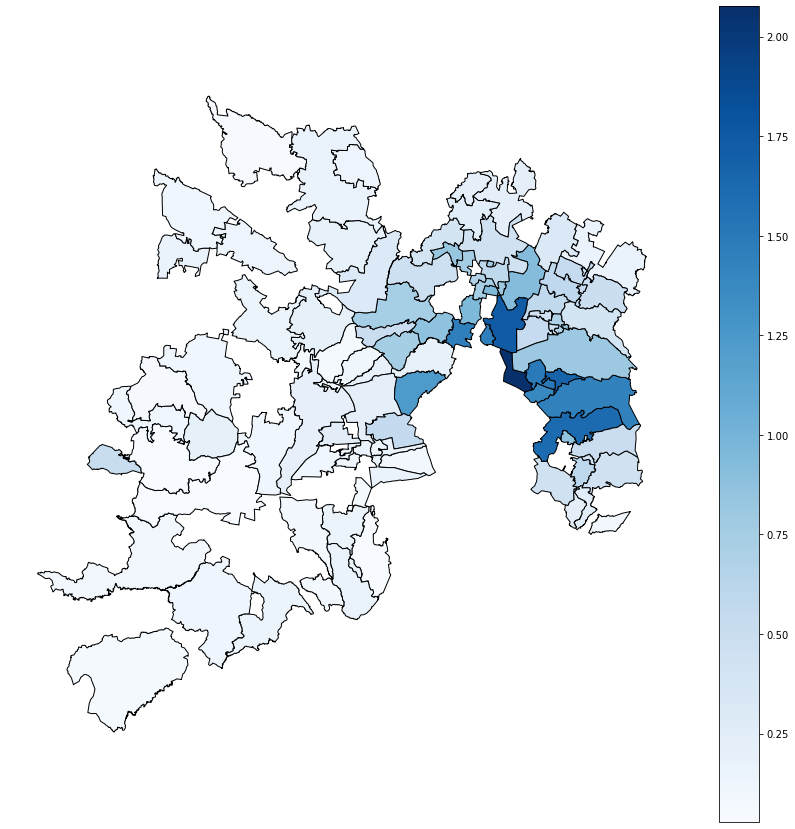

In [25]:
# Import GeoDataFrame with municipalities
Estado_mexico = gpd.read_file("15mun.dbf")

# Set to names with capital letters and merge with the Abortions per municipality Series Freq_municipal
Estado_mexico["NOMGEO"] = Estado_mexico["NOMGEO"].apply(upper)

Merged_Estado = pd.merge(Estado_mexico,Freq_municipal,left_on="NOMGEO",right_index=True)

# Import the 2015 population from a downloaded Excel file
Pop_Estado = pd.read_excel('Poblacion Estado.xls')

# Again, edit and merge with the GeoDataFrame
Pop_Estado["Nombre de municipio"] = Pop_Estado["Nombre de municipio"].apply(upper)
Merged_EP = pd.merge(Merged_Estado,Pop_Estado,left_on="NOMGEO",right_on="Nombre de municipio")

# Compute the ratio of abortions per population
Merged_EP["Ratio"] = 1000*Merged_EP["count"]/Merged_EP["Total"]

# Finally, plot
fig, gax = plt.subplots(figsize=(15,15))
plt.axis("off")

Merged_EP.plot(ax=gax, edgecolor = "black", column = "Ratio", cmap="Blues",legend=True);

Observing the map, it can be argued that those municipalities closest to Mexico City have the highest rates of abortion, merely because of the close and convenient distance to the city. While this is partially true, these municipalities are precisely the richest, most developed ones out of the whole State of Mexico. Indeed, this map reflects very accurately what poverty maps look like for this State (for example: https://www.coneval.org.mx/coordinacion/entidades/EstadodeMexico/Paginas/pob_municipal.aspx), with the darkest municipalities having the lowest poverty indices and the brightest having the highest. Again, this reiterates the point that abortion access is heavily determined by socioeconomic status.

*Note that this map isn't perfect, as there are many municipalities that haven't been matched properly when joining both datasets, probably because of differences in the municipalities' spelling, abbreviations and others. In the interest of time this will not be fixed, as the results can be seen even without the remaining municipalities.*

# Illegal Abortions in Mexico
Because of the illegal nature on abortions in most of Mexico, it's very hard to keep accurate records of actual number of abortions. There have been many estimates of this number, and they widely vary from study to study. The undeniable fact, however, is that this is a critical problem in today's Mexican society (and most of the developing world): according to the WHO, unsafe abortion accounts for up to 13% of deaths related to pregnancy and childbirth globally.

In this section, I'm investigating the nation-wide survey ENADID ("Encuesta Nacional de la Dinámica Demográfica ", or "National Survey of Demographic Dynamics"). It was done in 2018 and had questions on all areas of life, including housing, family, socioeconomic status, reproductive issues, migration, etc. I'm focusing here on the part of survey targeted specifically to women, in particular on those questions related to abortion and socioeconomic status. 

This dataset is incredibly large (over 100,000 respondents) and contains thousands of questions, so I will only provide explanations for the questions I consider pertinent to the case. Again, because abortions are deemed illegal across most of Mexico, there's no direct questions about whether the woman has gone through an abortion. However, I can try to look for "hints" and indicators that increase the likelihood of identifying a case of abortion. In particular, I will refer to: 

- Question 5_22, which asks whether the woman has been pregnant in the last 5 years but lost the child before birth. If the woman responds affirmatively, she could have had either an induced abortion or a miscarriage.
- Question 7_11, which asks, in case the woman has children, if she would like to have any more kids. 
- Question 7_7, which asks, in case the woman has no children, if she would like to have any kids at all.

I will group those who respond "Yes" to Question 5_22 with those who repond "No" to either 7_11 or 7_7, and I will identify them as the "presumably induced abortion" group. This follows the logic that, if a woman has had a miscarriage or an induced abortion, AND she doesn't want any (more) kids, the likelihood of it being an induced abortion is higher than it being a miscarriage. I do recognise the limitations of this approach: some of these women may have suffered a miscarriage and not an abortion, even though they didn't want (more) kids. However, due to the difficulty of estimating these results I'll approximate the true value to this. Moreoverm it's worth noting that while this number may be overestimating, official census like this one usually underestimate the data on abortions in countries where abortions are illegal (since women might fear facing legal consequences if they disclose the information), hence the number estimated here might not be that far off the actual one. 


In [26]:
# From ENADID Survey, import "Mujer" (woman) dataset - only those questions asked specifically to women
Dataset1 = pd.read_csv("TMujer1.csv")

# Locate question 5_22 and group by affirmative answer, represented by "1" in the survey's responses
Q5_22 = Dataset1.loc[:,"p5_22"]
Abortion_or_miscarriage = Dataset1.groupby("p5_22").get_group("1") 

# if have kids, these responded NO to "do you want to have more kids?"
with_kids = Abortion_or_miscarriage.groupby("p7_11").get_group("3") 

# if they don't have kids, these responded NO to "do you want to have kids?" 
without_kids = Abortion_or_miscarriage.groupby("p7_7").get_group("3")

print(with_kids.info())
print(without_kids.info())

# Merge the 2 groups (with and without kids)
total_abortions = pd.concat([with_kids,without_kids])
total_abortions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9893 entries, 2 to 108427
Columns: 214 entries, upm to upm_dis
dtypes: int64(62), object(152)
memory usage: 16.2+ MB
None
<class 'pandas.core.frame.DataFrame'>
Index: 258 entries, 69 to 108178
Columns: 214 entries, upm to upm_dis
dtypes: int64(62), object(152)
memory usage: 433.4+ KB
None
<class 'pandas.core.frame.DataFrame'>
Index: 10151 entries, 2 to 108178
Columns: 214 entries, upm to upm_dis
dtypes: int64(62), object(152)
memory usage: 16.7+ MB


In [27]:
# compute the total number of women who reported a pregnancy in the last 5 years
# drop the " " as it represents women who didn't respond the question, so they hadn't had a pregnancy
total_pregnancies = Q5_22.value_counts().drop(" ").sum() 

# Compute the proportion of presumed abortions relative to the total number of pregnancies
pct_abortions = 100*len(total_abortions)/total_pregnancies
print(f"Result: {pct_abortions:.2f}% of pregnancies registered in the last 5 years presumably ended in abortion")

# Compute the proportion of presumed abortions over the total sample of women
total_women = len(Dataset1.index)
pct_abortions_over_total = 100*len(total_abortions)/total_women
print(f"Result: {pct_abortions_over_total:.2f}% of women in the sample presumably had an abortion the last 5 years")


Result: 13.07% of pregnancies registered in the last 5 years presumably ended in abortion
Result: 9.36% of women in the sample presumably had an abortion the last 5 years


## Comparison: Safe vs. Unsafe Abortion Access

Because the ENADID survey was carried out all across Mexico, the responses come from women from every state, not just Mexico City and State of Mexico. We saw earlier that the women accessing legal abortion services in Mexico City mainly came from the city or the neighbouring states. This means that the women I've classified as "presumed abortion" from the ENADID survey are likely to have undergone such abortion illegally, as still do most women in Mexico. Ideally, we'd want to compare the socioeconomic status of those women who had access to legal abortion services (Abortion_2016_18 dataset) with those who didn't (ENADED survey dataset) to see if there are any relevant differences. Because of the different nature of both surveys, there's not many overlapping questions. However, both datasets contain one key question, especially relevant in this context: education level. I will now plot and compare the responses to this question.

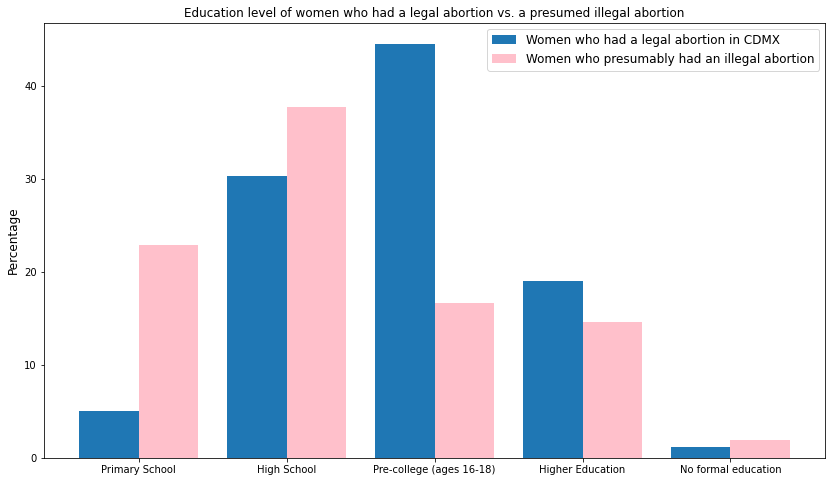

In [32]:
X_axis = np.arange(5)
fig, ax = plt.subplots(figsize=(14,8))

# Recover education levels of women who had a legal abortion in Mexico City
CDMX_ab_edu = Abortion_Edu

# Compute the relative frequency of the highest education level achieved by women in the "presumed abortion" sample
# The education levels are found in column "niv"
Total_ab_edu = 100*total_abortions["niv"].value_counts()/(total_abortions["niv"].value_counts().sum())

# Drop kinder (1), "Normal Basica" (teachers education) (4), and Technical training (5,7) because of their small percentage
Total_ab_edu.drop([1,4,5,7],inplace=True)

# Group Bachelor's Degree (8), Speciality (9), Master's (10) and PhD (11) into "Higher Education" and drop them
Total_ab_edu["Higher Education"] = Total_ab_edu[8]+Total_ab_edu[9]+Total_ab_edu[10]+Total_ab_edu[11]
Total_ab_edu.drop([8,9,10,11],inplace=True)

# Rearrange in order of increasing education levels
Total_ab_edu = Total_ab_edu.iloc[[1,0,2,4,3]]

# Plot
plt.bar(X_axis - 0.2, CDMX_ab_edu, 0.4, label = 'Women who had a legal abortion in CDMX')
plt.bar(X_axis + 0.2, Total_ab_edu, 0.4, label = 'Women who presumably had an illegal abortion',color="pink");

ax.set_title("Education level of women who had a legal abortion vs. a presumed illegal abortion")
ax.set_ylabel("Percentage",fontsize=12)
ax.set_xticks([0,1,2,3,4],["Primary School", "High School","Pre-college (ages 16-18)","Higher Education","No formal education"])
ax.legend(fontsize=12);

It can be clearly seen from this graph that women who had access to legal abortions in Mexico City (CDMX) had a much higher level of education compared to those who didn't have access to legal abortions. We see this through the overrepresentation of women without access to legal abortions in the lower bands (Primary School and High School), whereas if we look at the upper bands (Pre-college and Higher Education), it's the women who had access to legal abortions who are much more likely to have achieved such high levels of education. 

This concludes the analysis of factors determining access to legal abortion services in Mexico - it is clear by now that a more highly educated background, as well as residency in a developed municipality and proximity to Mexico City, all are linked to higher abortion access. Other factors such as being single, being a student and being young are linked to higher rates of abortion, not so much because of increased access, but rather because of socioeconomical factors which make it more costly for these groups of women to have children.

Areas of further research include comparison of socioeconomic status of both the "legal abortion" group and the "presumably illegal abortion" group through comparing the income earned by these women, as well as their urban/rural status and their indigeneity.

### References and links to Databases:

- Average age of marriage: https://www.inegi.org.mx/contenidos/saladeprensa/boletines/2021/EstSociodemo/Matrimonios2021.pdf, page 6.

- WHO unsafe abortion statistics: https://apps.who.int/iris/bitstream/handle/10665/329887/WHO-RHR-19.21-eng.pdf?sequence=1&isAllowed=y

- Link to SIESVIM (Spanish): https://sc.inegi.org.mx/SIESVIM1/paginas/consultas/tablero.jsf

- INEGI Report (Spanish): http://cedoc.inmujeres.gob.mx/documentos_download/MHM_2016.pdf

- INEGI 2020 census (Spanish): https://www.inegi.org.mx/programas/ccpv/2020/default.html#Resultados_generales

- National GeoStatistical Framework (INEGI): http://en.www.inegi.org.mx/temas/mg/#Downloads

- ENADID Survey (Spanish): https://www.inegi.org.mx/rnm/index.php/catalog/554/data-dictionary/F7?file_name=TMujer2